# Ames Housing Price Analysis

This notebook demonstrates a **step-by-step** workfor predicting house prices.
Here:

1. **Split** the data.
2. **Use** the target (Sale Price) distribution.
3. **Explore** feature correlations and outliers.
4. **Smart** feature engineering (adding Distance_To_Center, etc.).
5. **Custom** SGD regressor.
6. **Visualize** training dynamics (loss, weight norms).
7. **Compare** multiple models (Base Pipeline, OneHot Pipeline, SGD Regressor, Exponential Pipeline) of MAE and RMSLE.

Ok, we are ready!

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Custom modules:
from scripts.pipeline import get_continuous_columns, get_categorical_columns
from scripts.pipeline import make_base_pipeline, make_onehot_pipeline
from scripts.models import SGDLinearRegressor, ExponentialLinearRegression
from scripts.preprocessors import BaseDataPreprocessor, SmartDataPreprocessor
from scripts.metrics import root_mean_squared_logarithmic_error

sns.set_theme()
sns.set_palette("husl")

seed = 24
np.random.seed(seed)

data = pd.read_csv('data/data.csv')  # Check path
target_column = 'Sale_Price'

test_size = 0.2
data_train, data_test, y_train, y_test = train_test_split(
    data.drop(columns=[target_column]),
    data[target_column].values,
    test_size=test_size,
    random_state=seed
)

# For convenience, attach Sale_Price back to data_train and data_test
data_train = data_train.copy()
data_test = data_test.copy()
data_train[target_column] = y_train
data_test[target_column] = y_test

print(f"Train : {data_train.shape} {y_train.shape}")
print(f"Test : {data_test.shape} {y_test.shape}")

Train : (2344, 81) (2344,)
Test : (586, 81) (586,)


## 1. Target Analysis

Now we will explore `Sale_Price` distribution.

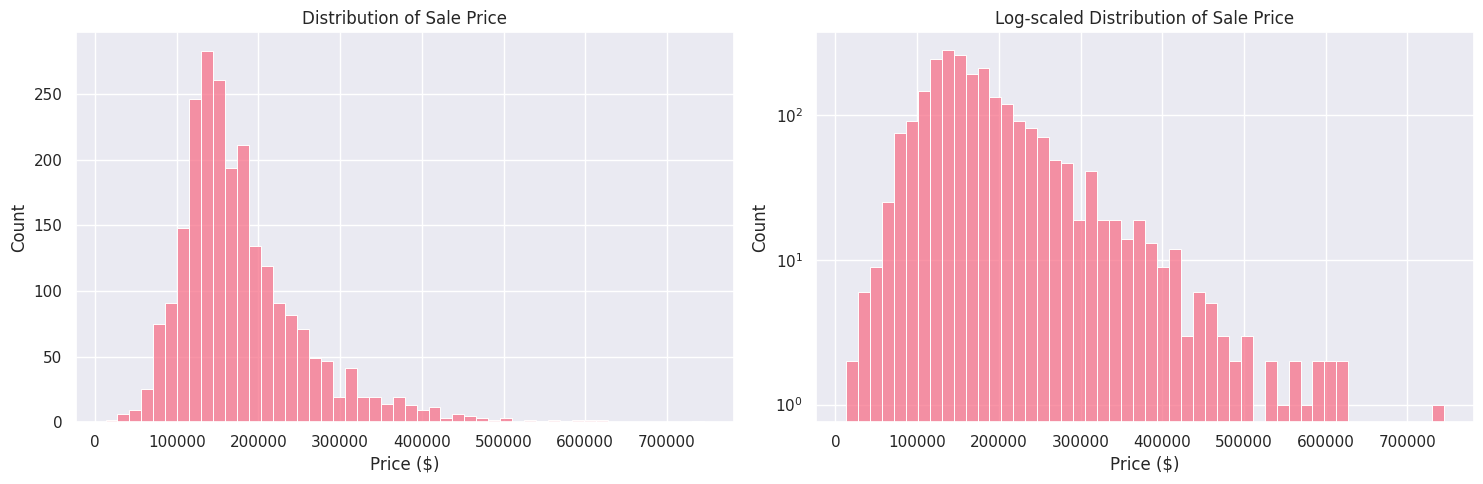

In [2]:
def plot_target_distribution(data_train: pd.DataFrame, price_column: str="Sale_Price") -> None:
    """Analyze Sale_Price distribution with normal and log scales"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Original distribution
    sns.histplot(data=data_train, x=price_column, bins=50, ax=ax1)
    ax1.set_title('Distribution of Sale Price')
    ax1.set_xlabel('Price ($)')
    
    # Log-scaled y-axis
    sns.histplot(data=data_train, x=price_column, bins=50, ax=ax2)
    ax2.set_yscale('log')
    ax2.set_title('Log-scaled Distribution of Sale Price')
    ax2.set_xlabel('Price ($)')
    
    plt.tight_layout()
    plt.show()

plot_target_distribution(data_train, price_column=target_column)

We see that log-transformed price helps normalize the distribution and can lead to better model performance.

## 2. Feature Correlation

Now let's visualize the correlation matrix among continuous features.

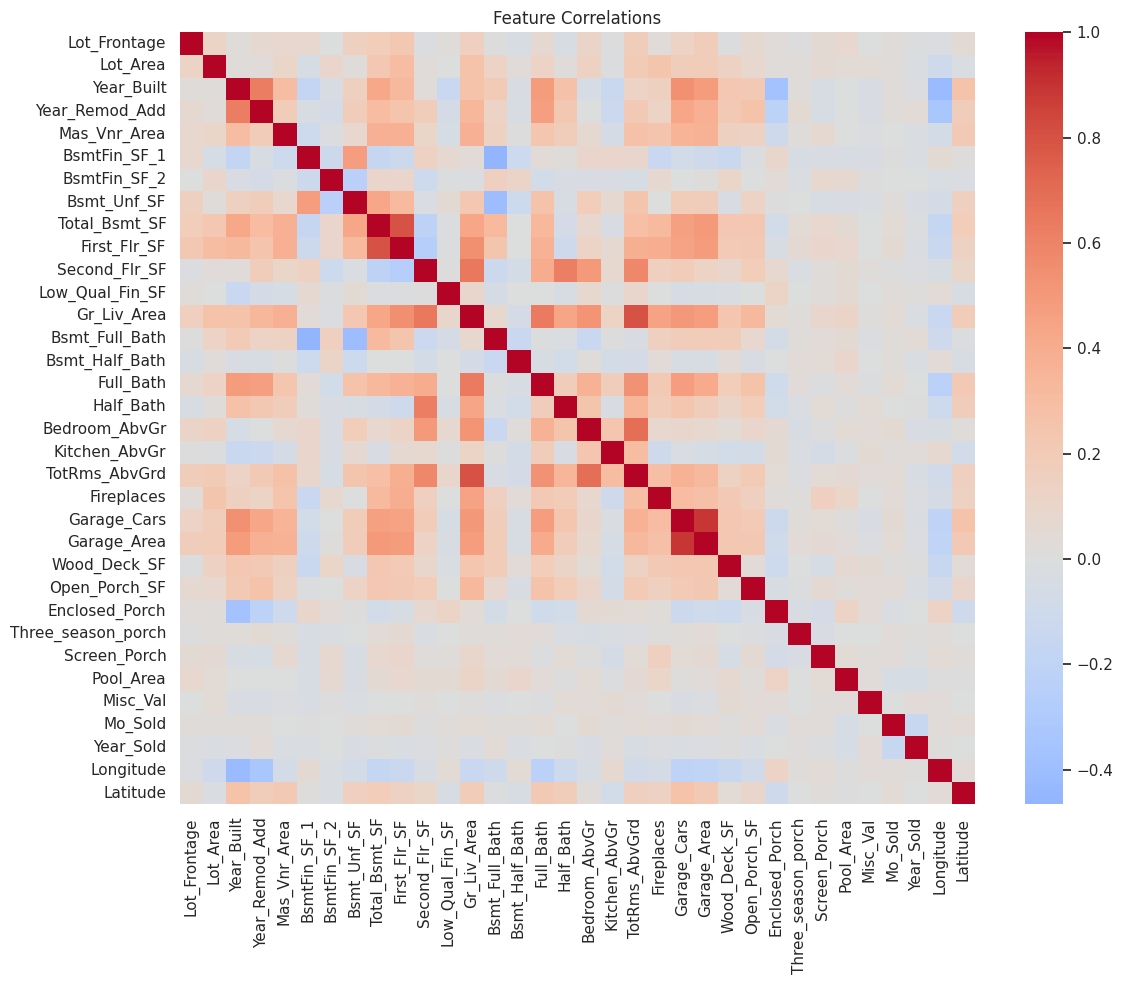

In [3]:
def plot_correlation_matrix(data_train: pd.DataFrame) -> None:
    """Visualize correlations between numerical features"""
    continuous_cols = get_continuous_columns()
    plt.figure(figsize=(12, 10))
    correlation_matrix = data_train[continuous_cols].corr()
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
    plt.title('Feature Correlations')
    plt.tight_layout()
    plt.show()

plot_correlation_matrix(data_train)

We see that in the heatmap there are positive correlations between related features like Garage_Cars and Garage_Area, for example.

For 'Sale_Price' could be important location-based features (Longitude, Latitude). Also they show weak correlations with other features.

## 3. "Smart" Preprocessing Analysis

Here, we want to see how our **SmartDataPreprocessor** show correlation between features `Distance_To_Center` and `Sale_Price`.

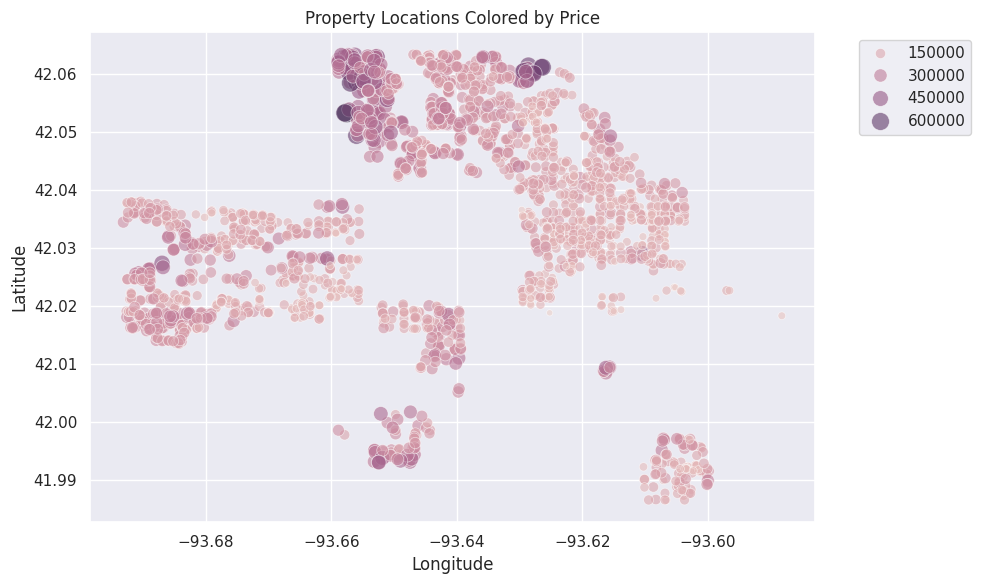

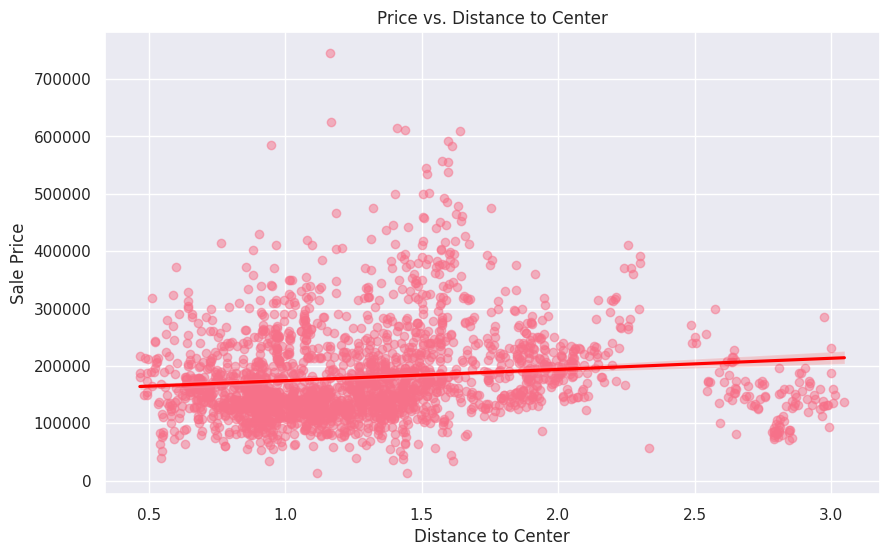

In [4]:
def analyze_smart_preprocessing(data_train: pd.DataFrame) -> None:
    """Compare base and smart preprocessing approaches, focusing on location-based features."""
    numeric_cols = get_continuous_columns()
    data_for_analysis = data_train[numeric_cols].copy()

    if 'Longitude' in data_train.columns and 'Latitude' in data_train.columns:
        plt.figure(figsize=(10, 6))
        scatter = sns.scatterplot(
            data=data_train,
            x='Longitude',
            y='Latitude',
            hue='Sale_Price',
            size='Sale_Price',
            sizes=(20, 200),
            alpha=0.6
        )
        plt.title('Property Locations Colored by Price')
        scatter.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    # Process data with SmartDataPreprocessor
    smart_preprocessor = SmartDataPreprocessor()
    smart_data = smart_preprocessor.fit_transform(data_for_analysis)

    # Plot distance-to-center vs. Sale_Price
    plt.figure(figsize=(10, 6))
    sns.regplot(
        x=smart_data[:, -1], 
        y=data_train['Sale_Price'],
        scatter_kws={'alpha':0.5},
        line_kws={'color': 'red'}
    )
    plt.xlabel('Distance to Center')
    plt.ylabel('Sale Price')
    plt.title('Price vs. Distance to Center')
    plt.show()

# Call the function
analyze_smart_preprocessing(data_train)

We see distinct neighborhood clusters with higher-priced properties. Probably, location value is more about specific neighborhoods rather than simple distance from a central point.

## 4. SGD Dynamics

Now analyze how our **SGDLinearRegressor** converges. There are three graphs for:
- **Loss** history
- **Weight Norm** history
- **Gradient Norm** history

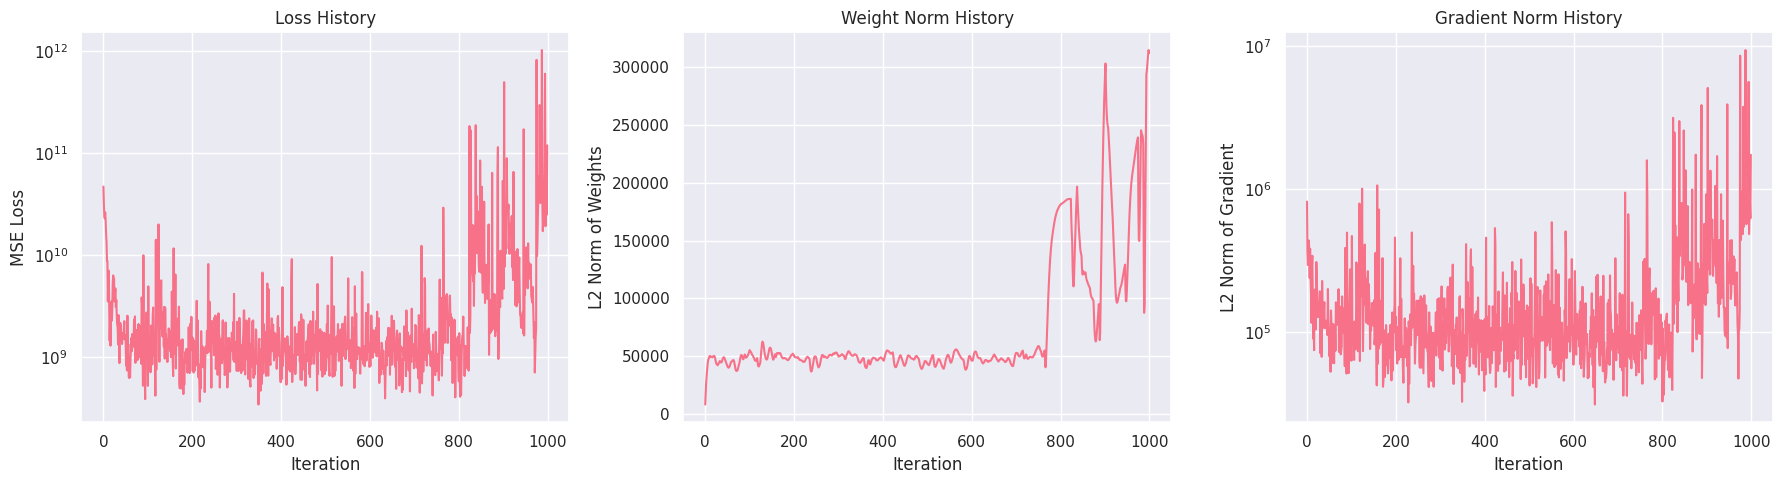

In [5]:
def plot_sgd_training_history(model: SGDLinearRegressor, data_train: pd.DataFrame, y_train: np.ndarray):
    """Train the SGD model and visualize its training dynamics."""
    numeric_cols = get_continuous_columns()
    X_train = data_train[numeric_cols].values
    
    # Scale the features
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)

    # (Optional) we could also scale y, but let's keep it simpler.
    model.fit(X_train_scaled, y_train)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Loss history
    ax1.plot(model.loss_history)
    ax1.set_title('Loss History')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('MSE Loss')
    ax1.set_yscale('log')

    # Weight norm history
    ax2.plot(model.weight_norm_history)
    ax2.set_title('Weight Norm History')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('L2 Norm of Weights')

    # Gradient norm history
    ax3.plot(model.gradient_norm_history)
    ax3.set_title('Gradient Norm History')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('L2 Norm of Gradient')
    ax3.set_yscale('log')

    plt.tight_layout()
    plt.show()

# Instantiate and visualize
sgd_model = SGDLinearRegressor()
plot_sgd_training_history(sgd_model, data_train, y_train)

We see that 0-800 iterations shows more stable behavior with consistent loss and weight norm.
After 800 iterations we see that our model is overfitting.

## 5. Model Comparison

We'll compare:
- **Base Pipeline** (numeric features only)
- **OneHot Pipeline** (includes selected categorical features)
- **Exponential Pipeline** (includes selected categorical features)
- **SGD Regressor** (custom)  


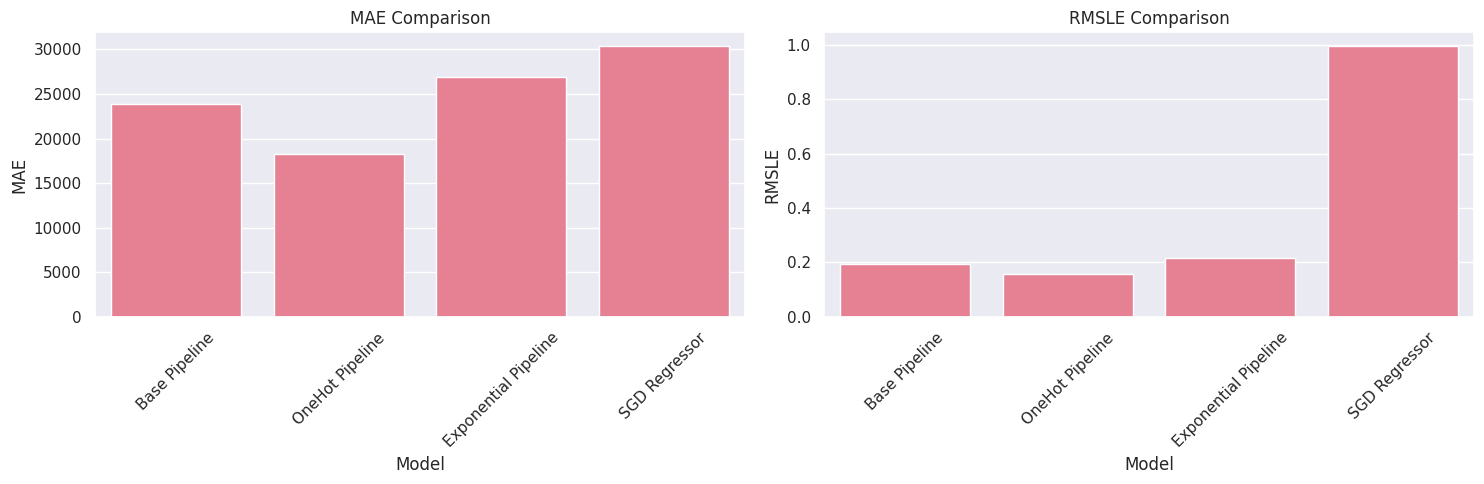

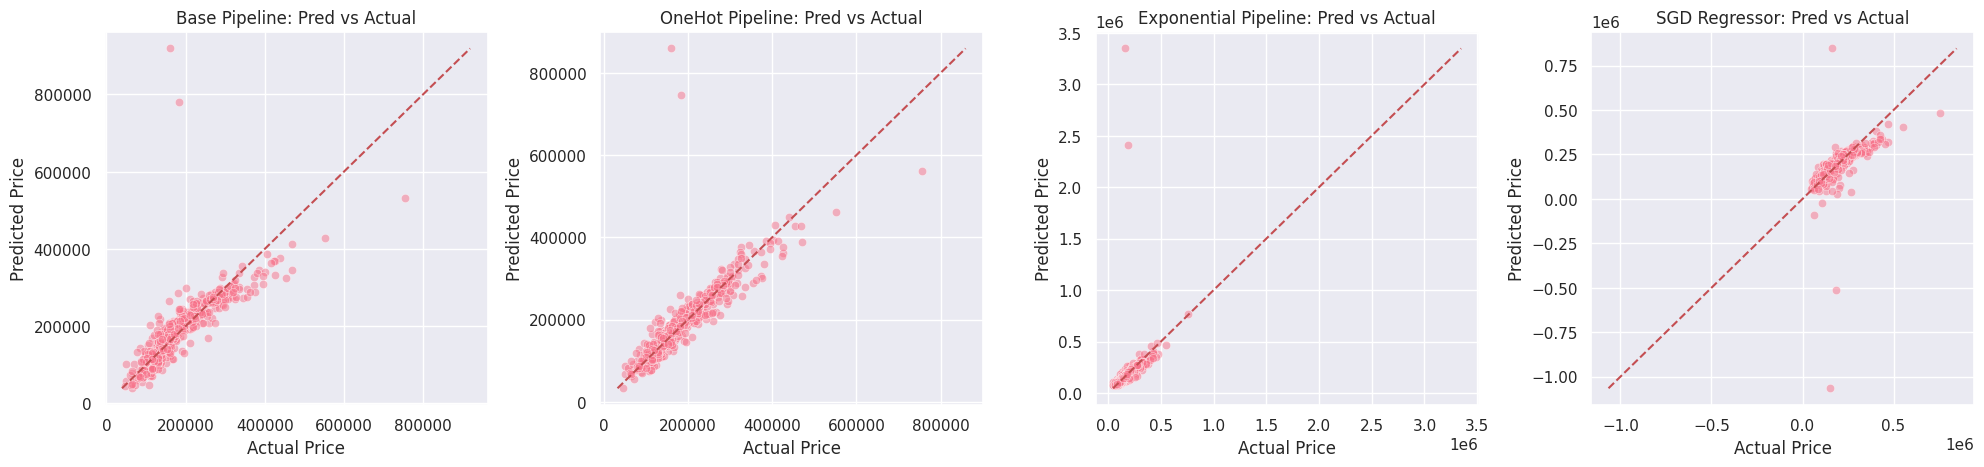

In [7]:
def compare_models(data_train: pd.DataFrame, y_train: np.ndarray, 
                  data_test: pd.DataFrame, y_test: np.ndarray) -> None:
    """Compare different models using various metrics (MAE, RMSLE) and scatter plots."""
    numeric_cols = get_continuous_columns()
    
    # Prepare scaled data for some models
    X_train = data_train[numeric_cols].values
    X_test = data_test[numeric_cols].values

    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    results = {'Model': [], 'MAE': [], 'RMSLE': []}
    predictions_dict = {}

    # 1) Base Pipeline
    base_model = make_base_pipeline()
    base_model.fit(data_train, y_train)
    pred_base = base_model.predict(data_test)
    predictions_dict['Base Pipeline'] = pred_base
    results['Model'].append('Base Pipeline')
    results['MAE'].append(mean_absolute_error(y_test, pred_base))
    results['RMSLE'].append(root_mean_squared_logarithmic_error(y_test, pred_base))

    # 2) OneHot Pipeline
    onehot_model = make_onehot_pipeline()
    onehot_model.fit(data_train, y_train)
    pred_onehot = onehot_model.predict(data_test)
    predictions_dict['OneHot Pipeline'] = pred_onehot
    results['Model'].append('OneHot Pipeline')
    results['MAE'].append(mean_absolute_error(y_test, pred_onehot))
    results['RMSLE'].append(root_mean_squared_logarithmic_error(y_test, pred_onehot))

    # 3) Exponential Pipeline
    preprocessor = SmartDataPreprocessor()
    X_train_preprocessed = preprocessor.fit_transform(data_train)
    X_test_preprocessed = preprocessor.transform(data_test)
    
    model = ExponentialLinearRegression()
    model.fit(X_train_preprocessed, y_train)
    pred = model.predict(X_test_preprocessed)
    predictions_dict['Exponential Pipeline'] = pred
    results['Model'].append('Exponential Pipeline')
    results['MAE'].append(mean_absolute_error(y_test, pred))
    results['RMSLE'].append(root_mean_squared_logarithmic_error(y_test, pred))

    # 4) SGD Regressor
    sgd_model = SGDLinearRegressor()
    sgd_model.fit(X_train_scaled, y_train)
    pred_sgd_scaled = sgd_model.predict(X_test_scaled)
    pred_sgd = pred_sgd_scaled  # If we had scaled y, we would invert here

    predictions_dict['SGD Regressor'] = pred_sgd
    results['Model'].append('SGD Regressor')
    results['MAE'].append(mean_absolute_error(y_test, pred_sgd))
    results['RMSLE'].append(root_mean_squared_logarithmic_error(y_test, pred_sgd))

    results_df = pd.DataFrame(results)

    # Bar chart comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.barplot(data=results_df, x='Model', y='MAE', ax=ax1)
    ax1.set_title('MAE Comparison')
    ax1.tick_params(axis='x', rotation=45)

    sns.barplot(data=results_df, x='Model', y='RMSLE', ax=ax2)
    ax2.set_title('RMSLE Comparison')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Scatter plots: predicted vs. actual
    fig, axes = plt.subplots(1, len(predictions_dict), figsize=(5*len(predictions_dict), 5))
    if len(predictions_dict) == 1:
        axes = [axes]

    for i, (name, pred) in enumerate(predictions_dict.items()):
        sns.scatterplot(x=y_test, y=pred, ax=axes[i], alpha=0.5)
        min_val = min(y_test.min(), pred.min())
        max_val = max(y_test.max(), pred.max())
        axes[i].plot([min_val, max_val], [min_val, max_val], 'r--')
        axes[i].set_title(f'{name}: Pred vs Actual')
        axes[i].set_xlabel('Actual Price')
        axes[i].set_ylabel('Predicted Price')

    plt.tight_layout()
    plt.show()

# Compare our models
compare_models(data_train, y_train, data_test, y_test)

The OneHot Pipeline consistently outperforms other models across both metrics, showing the lowest MAE (~18,000) and lowest RMSLE (~0.155). The SGD Regressor performs worst overall with highest errors in both metrics, while the Base Pipeline and Exponential Pipeline show intermediate performance, suggesting that proper categorical feature encoding (OneHot) is crucial for this prediction task.

The OneHot Pipeline shows the best performance among all models, with predictions closely following the perfect prediction line (red dashed) and fewer outliers. All models tend to underestimate prices for high-value properties (>400,000), with the SGD Regressor showing the most significant deviation at higher price points, suggesting that expensive houses might have unique features not well captured by the current feature set.

## 6. Conclusions

- **Distribution**: house prices have a clear right-skewed distribution, so log-transformed price is better for modeling.
- **Smart Preprocessing**: property values are more influenced by specific neighborhood clusters than distance to center.
- **SGD**: unstable behavior after 800 iterations, suggesting that early stopping and learning rate tuning could improve performance.
- **OneHot Pipeline**: has the best performance across all metrics.

Thank you for your attention!   